In [1]:
# Import necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import time

# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py
from sklearn.metrics import accuracy_score

In [2]:
# Make sure that CUDA is available - without cuda we would be attempting to run the model on CPU which is tooooo slow. 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

# Parameter
### Dataset path

In [3]:
# Check if dataset is present
import os.path
# dataset_path = "datasets/MatGenData.h5"
# dataset_path = "datasets/MatGenData_0PPM.h5"
dataset_path = "datasets/new_normalized/MatGenData_0_ppm_Rician_10062025.h5"
os.path.isfile(dataset_path)

True

### Dataset property parameters

In [4]:
from experimental.dataset_tools import radioml_dataset, full_linear_scale_quantizer, simple_linear_scale_quantizer, base_dataset_quantizer
# data_key='all_IQ_int8'
data_key='all_IQ_float32'
mod_key='all_labels'
snr_key='all_SNRs'
snr_lower_bound=0.0
snr_upper_bound=30.0
snr_steps=2.0

mod_classes = ["BPSK", 
                "QPSK", 
                "8PSK",
                "16QAM",
                "32QAM", 
                "64QAM", 
                "128QAM", 
                "256QAM",
                "16APSK", 
                "32APSK", 
                "64APSK", 
                "128APSK",
                "FM", 
                "AM-DSB-SC", 
                "AM-SSB-SC"]

snr_classes = np.arange(snr_lower_bound,
                        snr_upper_bound+1.0,
                        snr_steps) 

#play around with these
quantization_dtype=np.int8

## Create dataset object

In [5]:
quantizer=simple_linear_scale_quantizer(3.2, 128, np.int8)

dataset = radioml_dataset(dataset_path=dataset_path,
                          data_key=data_key, mod_key=mod_key, snr_key=snr_key,
                          mod_classes=mod_classes,snr_classes=snr_classes,
                          dataset_quantizer=quantizer,
                          frame_per_mod_snr_combination=4096) 

debug_quantized_dataset=quantizer.quantize(dataset.data[:])

print('Raw value range: (',np.min(dataset.data),' ; ',np.max(dataset.data),')  ',dataset.data.dtype) 
print('Quantized value range: (',np.min(debug_quantized_dataset),' ; ',np.max(debug_quantized_dataset),')  ',debug_quantized_dataset.dtype) 
print('Total mods: ', len(dataset.mod_classes))
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',
      dataset.data.shape[0]/(len(dataset.mod_classes)*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ', dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Val set size: ',len(dataset.val_sampler))
print('Test set size: ',len(dataset.test_sampler))

All available keys: ['all_IQ_float32', 'all_IQ_int8', 'all_SNRs', 'all_labels']
Extracting data key all_IQ_float32
Get labels
Get SNR
Raw value range: ( -5.7020364  ;  5.0702124 )   float32
Quantized value range: ( -128  ;  127 )   int8
Total mods:  15
Number of SNRs:  16
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]  

Total size:  (983040, 1024, 2)
Training set size:  786480
Val set size:  98400
Test set size:  98160


# Some visualizations of Dataset

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

raw_sample = dataset.data[:]  #Get the data as (1,2,1024)
# Flatten the array to 1D
raw_flattened = raw_sample.flatten()  
quantized_flatten = debug_quantized_dataset.flatten()  

## Histogram plotting values vs their frequencies

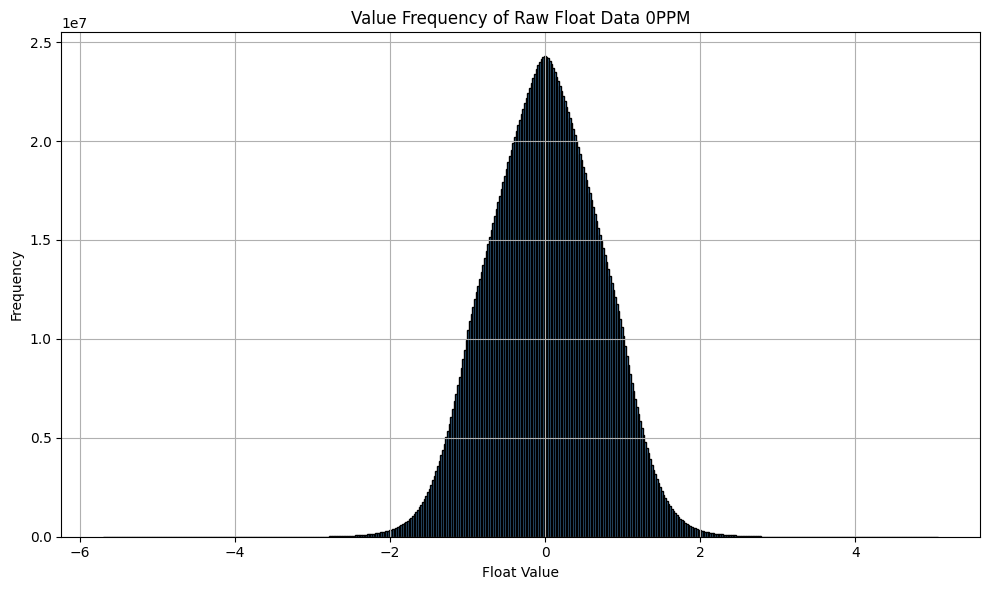

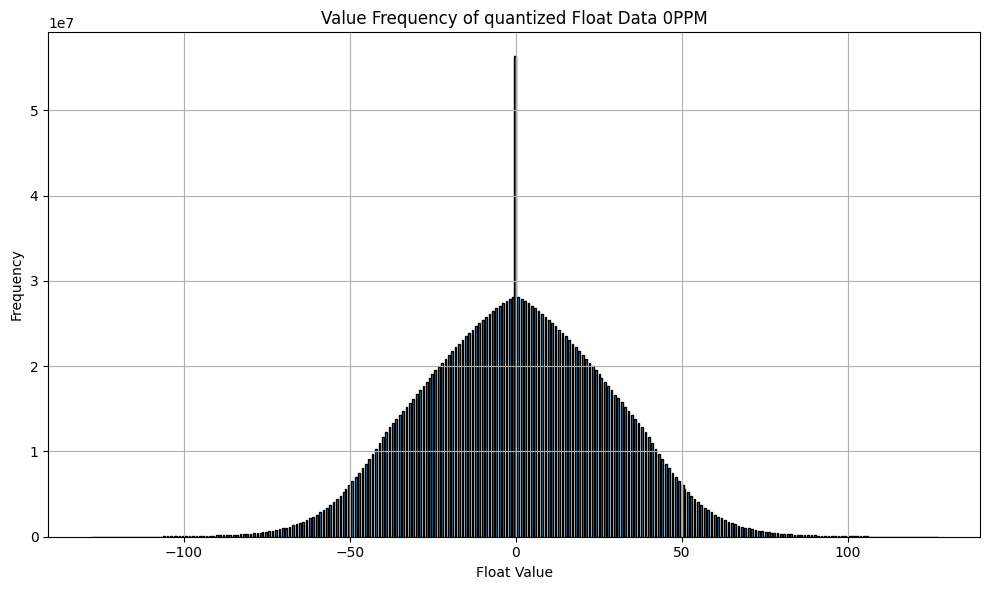

In [7]:
# Plot raw dataset histogram
plt.figure(figsize=(10, 6))
plt.hist(raw_flattened, bins=500, color='steelblue', edgecolor='black', density=False)
plt.title('Value Frequency of Raw Float Data 0PPM')
plt.xlabel('Float Value')
plt.ylabel('Frequency')

plt.grid(True)
plt.tight_layout()
plt.show()

# Plot quantized dataset histogram
plt.figure(figsize=(10, 6))
plt.hist(quantized_flatten, bins=500, color='steelblue', edgecolor='black', density=False)
plt.title('Value Frequency of quantized Float Data 0PPM')
plt.xlabel('Float Value')
plt.ylabel('Frequency')

plt.grid(True)
plt.tight_layout()
plt.show()

## Visualize a raw frame vs its quantized frame

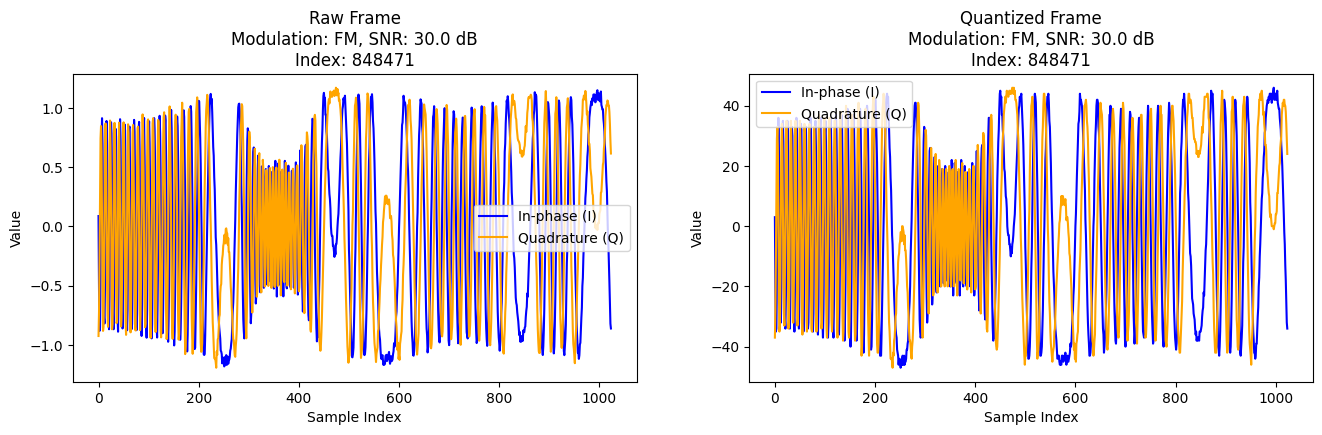

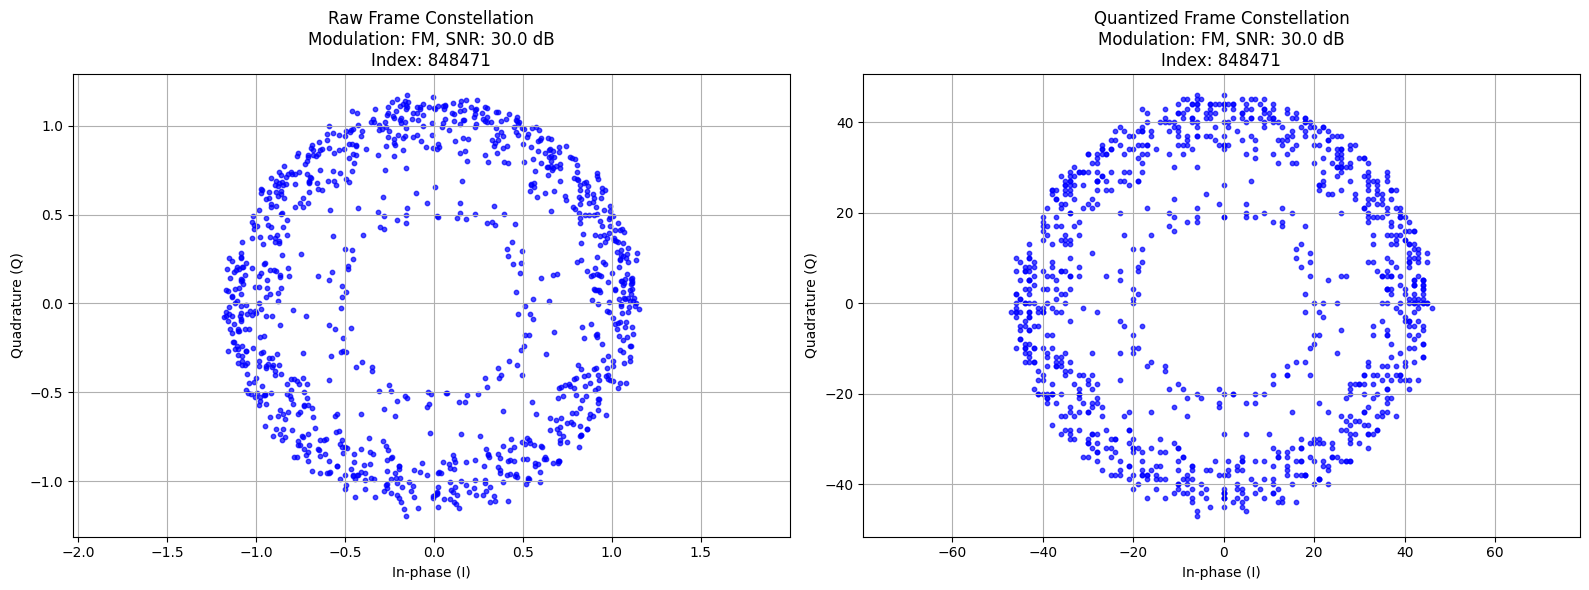

In [8]:
# Inspect a frame
fpmsc=dataset.frame_per_mod_snr_combination
#---------------Parameters--------
mod=12
snr_idx=999
sample=599

#limit parameters to avoid going out of range
mod = np.clip(mod,0,len(dataset.mod_classes)-1) 
snr_idx = np.clip(snr_idx,0,len(dataset.snr_classes)-1) 
sample = np.clip(sample,0,fpmsc-1) 

idx = len(dataset.snr_classes)*fpmsc*mod + fpmsc*snr_idx + sample

# Get raw frame
raw_data, raw_mod, raw_snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]

# Get quantized frame
quant_data, quant_mod, quant_snr = dataset.__getitem__(idx)
quant_data = quant_data.transpose()

#---------------------Value over time-----------#
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

#----- Plot raw frame -----
axs[0].plot(raw_data[:, 0], label='In-phase (I)', color='blue')
axs[0].plot(raw_data[:, 1], label='Quadrature (Q)', color='orange')
axs[0].set_title("Raw Frame\nModulation: %s, SNR: %.1f dB\nIndex: %d" %
                 (dataset.mod_classes[raw_mod], raw_snr, idx))
axs[0].set_xlabel("Sample Index")
axs[0].set_ylabel("Value")
axs[0].legend()

#----Plot quantized frame ----
axs[1].plot(quant_data[:, 0], label='In-phase (I)', color='blue')
axs[1].plot(quant_data[:, 1], label='Quadrature (Q)', color='orange')
axs[1].set_title("Quantized Frame\nModulation: %s, SNR: %.1f dB\nIndex: %d" %
                 (dataset.mod_classes[quant_mod], quant_snr, idx))
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("Value")
axs[1].legend()

#------------------------Constellation-------------#
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot constellation for raw frame
axs[0].scatter(raw_data[:, 0], raw_data[:, 1], color='blue', s=10, alpha=0.7)
axs[0].set_title("Raw Frame Constellation\nModulation: %s, SNR: %.1f dB\nIndex: %d" %
                 (dataset.mod_classes[raw_mod], raw_snr, idx))
axs[0].set_xlabel("In-phase (I)")
axs[0].set_ylabel("Quadrature (Q)")
axs[0].grid(True)
axs[0].axis('equal')  # Equal scaling for x and y axes

# Plot constellation for quantized frame
axs[1].scatter(quant_data[:, 0], quant_data[:, 1], color='blue', s=10, alpha=0.7)
axs[1].set_title("Quantized Frame Constellation\nModulation: %s, SNR: %.1f dB\nIndex: %d" %
                 (dataset.mod_classes[quant_mod], quant_snr, idx))
axs[1].set_xlabel("In-phase (I)")
axs[1].set_ylabel("Quadrature (Q)")
axs[1].grid(True)
axs[1].axis('equal')

plt.tight_layout()
plt.show()

